## Visualize IMDB Reviews with WizMap

In this notebook, we demonstrate how to use WizMap to visualize a text dataset.

In [3]:
# Install wizmap
# !pip install --upgrade wizmap umap-learn
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 43.6 MB/s eta 0:00:00a 0:00:01


In [1]:
from glob import glob
from os.path import exists, join, basename
from tqdm import tqdm
from json import load, dump
from matplotlib import pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from quadtreed3 import Quadtree, Node
from scipy.sparse import csr_matrix
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
from typing import Tuple
from io import BytesIO
from umap import UMAP

import pandas as pd
import numpy as np
import ndjson
import requests
import urllib
import wizmap

SEED = 20230501

plt.rcParams['figure.dpi'] = 300

## 1. Extract Embeddings

We use Sentence Transformer to extract embeddings of IMDB reviews with a small pre-trained model [`all-MiniLM-L6-v2`](https://www.sbert.net/docs/pretrained_models.html#sentence-embedding-models/).

To save the time to run this notebook, we will use pre-extracted embeddings in this step. Feel free to uncomment the cells below to extract the embeddings yourself (takes about 8 minutes).

In [2]:
# # Load IMDB dataset
# from datasets import load_dataset
# imdb_data = load_dataset('imdb', split='train')
# imdb_texts = imdb_data['text']
# print('Loaded', len(imdb_texts), 'IMDB reviews.')

In [3]:
# # Load the pre-trained embedding model
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('all-MiniLM-L6-v2')

# # Encode all 25k reviews
# BATCH_SIZE = 128
# embeddings = model.encode(imdb_texts, batch_size=BATCH_SIZE, show_progress_bar=True)

In [5]:
# To save time, we will just load pre-extracted embeddings
EMBEDDING_URL = 'https://huggingface.co/datasets/xiaohk/embeddings/resolve/main/imdb/imdb-train-25k-all-MiniLM-L6-v2-embeddings.npz'
stream = requests.get(EMBEDDING_URL, stream=True)
embedding_data = np.load(BytesIO(stream.raw.read()))

In [6]:
imdb_reviews = embedding_data['texts']
imdb_embeddings = embedding_data['embeddings']

print(f'Loaded {len(imdb_reviews)} IMDB reviews')
print(f'Embedding shape: {imdb_embeddings.shape}')

Loaded 25000 IMDB reviews
Embedding shape: (25000, 384)


## 2. Dimensionality Reduction

Then, we apply dimensionality reduction techniques (e.g., UMAP, t-SNE, PCA) to project the embeddings from a 384-dimension space into a 2D space. Here we use UMAP, but you can use any dimensionality reduction technique you like.

To save the time to run this notebook, we will use the UMAP's default parameters. However, it's a good practice to tune the parameters when you are using WizMap on your own dataset.

In [7]:
reducer = UMAP(metric='cosine')
embeddings_2d = reducer.fit_transform(imdb_embeddings)

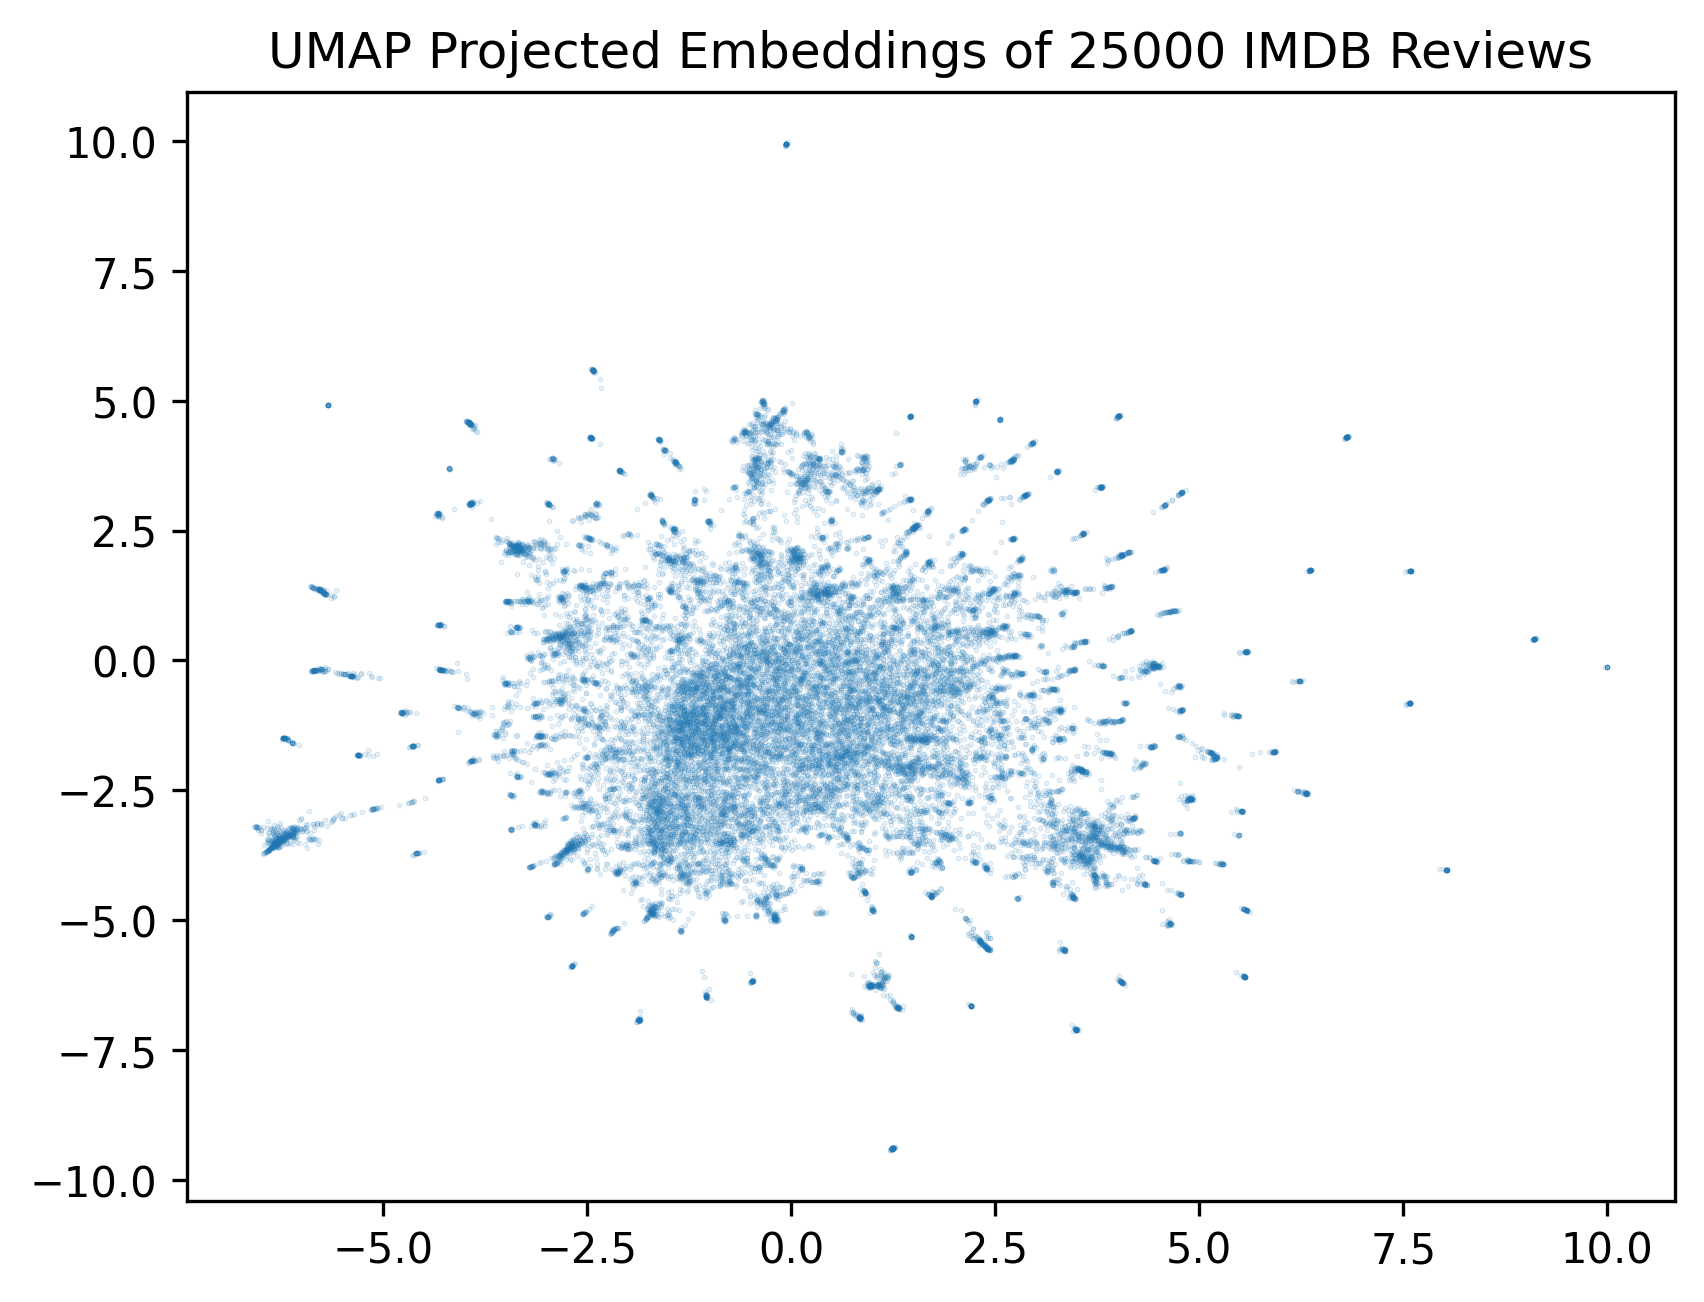

In [8]:
plt.title(f'UMAP Projected Embeddings of {len(imdb_reviews)} IMDB Reviews')
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=0.1, alpha=0.2)
plt.show()

## 3. Generate Two JSON Files for WizMap

To use WizMap on your embeddings, you need to generate two JSON files.

- One JSON file encodes the contour plot and multi-level summaries.
- The other JSON file encodes the raw data (e.g., IMDB reviews in this example).

Fortunately, the `WizMap` Python library makes it extremely easy to generate these two files. 

In [9]:
xs = embeddings_2d[:, 0].astype(float).tolist()
ys = embeddings_2d[:, 1].astype(float).tolist()
texts = imdb_reviews

In [10]:
data_list = wizmap.generate_data_list(xs, ys, texts)
grid_dict = wizmap.generate_grid_dict(xs, ys, texts, 'IMDB Reviews')

Start generating data list...
Start generating contours...
Start generating multi-level summaries...


25000it [00:00, 128537.56it/s]
100%|██████████| 6/6 [00:16<00:00,  2.70s/it]


In [11]:
# Save the JSON files
wizmap.save_json_files(data_list, grid_dict, output_dir='./')

## 4. Host JSON Files and Display WizMap

After generating these two JSON files (one with `.json` and one with `.ndjson`), you want to store them somewhere in the network so that you can provide two URLs to WizMap.

Depending on your needs, there are many options to store the files.

1. **Local host**. If you are running WizMap on your local machine, you can simply start a local server and use ‘local host’ URLs to send your JSON files to WizMap. 
2. **Static website hosting service** (e.g., GitHub page, Vercel, Hugging Face). You can use many free website hosting services to host your JSON files. A limitation is that these service usually have file size limits. For example, you can only include files that are less than 100MB in GitHub. 
3. **Cloud storage** (e.g., AWS S3, Cloudflare R2). The most general option is to put the JSON files on a cloud storage site. There is no size limit, but you might need to pay for the service.


Here, we store `data.ndjson` and `grid.json` in [Hugging Face](https://huggingface.co/datasets/xiaohk/embeddings/blob/main/imdb/).


In [12]:
data_url = 'https://huggingface.co/datasets/xiaohk/embeddings/resolve/main/imdb/data.ndjson'
grid_url = 'https://huggingface.co/datasets/xiaohk/embeddings/resolve/main/imdb/grid.json'

In [11]:

data_url = 'http://localhost:8000/data.ndjson'
grid_url = 'http://localhost:8000/grid.json'

In [16]:
# Display wizmap
wizmap.visualize(data_url, grid_url, height=700)

TypeError: visualize() missing 2 required positional arguments: 'data_url' and 'grid_url'

# 1. Extract the json file

load embeddings

In [3]:
from pipeline.utils import *

info_dict = load_info_dict()
#generate the matrix
# image_embeddings = torch.stack( [info['image_embedding'] for info in id_info_list])
# text_embeddings = torch.stack( [info['text_embedding'] for info in id_info_list])
id_info_list = load_id_info_list(info_dict)
image_embeddings = load_image_embeddings(info_dict)
text_embeddings = load_text_embeddings(info_dict)
image_embeddings = image_embeddings.cpu().numpy()
text_embeddings = text_embeddings.cpu().numpy()

reducer = UMAP(metric='cosine')
image_embeddings_2d = reducer.fit_transform(image_embeddings)
text_embeddings_2d = reducer.fit_transform(text_embeddings)



In [5]:
import wizmap
xs = image_embeddings_2d[:, 0].astype(float).tolist()
ys = image_embeddings_2d[:, 1].astype(float).tolist()
texts = [ele['text'] for ele in id_info_list]
data_list = wizmap.generate_data_list(xs, ys, texts)
grid_dict = wizmap.generate_grid_dict(xs, ys, texts, 'IMDB Reviews')
# Save the JSON files
wizmap.save_json_files(data_list, grid_dict, output_dir='./')

Start generating data list...
Start generating contours...
Start generating multi-level summaries...


476it [00:00, 77030.97it/s]
100%|██████████| 6/6 [00:00<00:00,  7.94it/s]
